# Fundamentals and Challenges of Generative Adversarial Networks for Image-based Applications
## SIBGRAPI 2022 Tutorial

Authors: Vinicius Luis Trevisan de Souza, Bruno Augusto Dorta Marques, João Paulo Gois

Universidade Federal do ABC (UFABC) - Centro de Matemática, Computação e Cognição

Full or partial reproduction is prohibited without the permission of the authors

# 3 - Pix2Pix

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf

In [3]:
from IPython import display

## Configs

In [4]:
BUFFER_SIZE = 500
BATCH_SIZE = 25
IMG_SIZE = 256
OUTPUT_CHANNELS = 3
LEARNING_RATE = 2e-4
ADAM_BETA1 = 0.5
LAMBDA_L1 = 100

In [5]:
EPOCHS = 30

## Dataset

In [6]:
# Preprocess pipeline
def image_preprocess_train(image_file, img_size, output_channels):
    """Loads a sample image for training"""
    
    # Format preprocessing
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    
    # Splits the input image from the target (real)
    w = tf.shape(image)[1]
    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    # Resize the images, if needed
    if input_image.shape[0] != img_size:
        input_image = tf.image.resize(input_image, [img_size, img_size])
    if real_image.shape[0] != img_size:
        real_image = tf.image.resize(real_image, [img_size, img_size])

    # Nomalize the images to the interval [-1, 1]
    input_image = tf.cast(input_image, tf.float32)
    input_image = (input_image / 127.5) - 1
    real_image = tf.cast(real_image, tf.float32)
    real_image = (real_image / 127.5) - 1
    
    return input_image, real_image

In [7]:
# String of the dataset folder path
dataset_folder = 'Datasets/pix2pix_dataset/data/'

In [8]:
# Create the dataset from the images on the folder
dataset = tf.data.Dataset.list_files(dataset_folder + '*.jpg')

In [9]:
# Check how many images are there
dataset_size = len(list(dataset))
dataset_size

2030

In [10]:
# Apply the preprocessing
dataset = dataset.map(lambda x: image_preprocess_train(x, IMG_SIZE, OUTPUT_CHANNELS))

In [11]:
# Caches the dataset
dataset = dataset.cache()

In [12]:
# Shuffle the dataset and split in batches
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

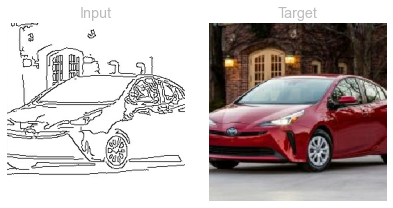

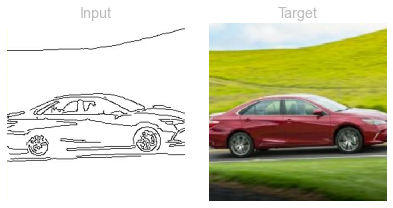

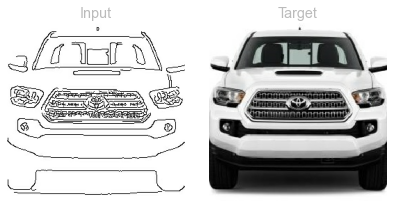

In [13]:
# Displays some sample image pairs
for batch_images in dataset.take(1):
    
    for i in range(min(3, BATCH_SIZE)):
        # Takes only one image from the batch
        input_img = batch_images[0][i]
        real_img = batch_images[1][i]

        # Embeds the images and respective titles
        images = [input_img, real_img]
        titles = ['Input', 'Target']

        # Plots the image pair
        plt.figure(figsize = (6, 3))
        for c, (img, title) in enumerate(zip(images, titles)):
            # Brings back the image to the [0, 1] range
            img = img * 0.5 + 0.5
            # Plots the image
            plt.subplot(1, 2, c + 1)
            plt.imshow(img)
            plt.title(title)
            # Getting the axis off
            plt.axis('off')
            plt.tight_layout()

## Network

In [14]:
normal_initializer = tf.random_normal_initializer(0., 0.02)

In [15]:
def downsample(filters, size, apply_norm=True):
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=normal_initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU(0.2))
    return result

In [16]:
def upsample(filters, size, apply_dropout=False):
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=normal_initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

### Generator

In [17]:
def Unet_Generator(IMG_SIZE, OUTPUT_CHANNELS):
    
    # Defines the down stack and the up stack
    down_stack = [
        downsample(64, 4, apply_norm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    # Initialize the inputs
    inputs = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, OUTPUT_CHANNELS])
    x = inputs

    # Encoder
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Decoder
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    # Last (RGB) layer
    x = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', 
                                        kernel_initializer=normal_initializer, activation='tanh')(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [18]:
gen = Unet_Generator(IMG_SIZE, OUTPUT_CHANNELS)

In [19]:
gen.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 64  3328        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  131584      ['sequential[0][0]']             
                                                                                              

### Discriminator

In [20]:
def Pix2Pix_Discriminator(IMG_SIZE, OUTPUT_CHANNELS):

    # Initialize the inputs
    inp = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, OUTPUT_CHANNELS])
    tar = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, OUTPUT_CHANNELS])
    x = tf.keras.layers.concatenate([inp, tar])

    # Creates the model
    x = downsample(64, 4, False)(x)
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)
    x = tf.keras.layers.ZeroPadding2D()(x)
    x = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=normal_initializer, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    # Adjustment for dimensions 30 x 30
    x = tf.keras.layers.ZeroPadding2D()(x)
    x = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=normal_initializer)(x)

    return tf.keras.Model(inputs=[inp, tar], outputs=x)

In [21]:
disc = Pix2Pix_Discriminator(IMG_SIZE, OUTPUT_CHANNELS)

In [22]:
disc.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

### Optimizers

In [23]:
g_opt = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1 = ADAM_BETA1)

In [24]:
d_opt = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1 = ADAM_BETA1)

## Losses

In [25]:
BCE = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [26]:
# Loss adversária do gerador
@tf.function
def pix2pix_generator_loss(disc_fake_output, fake_img, target, lambda_l1):
    gan_loss = BCE(tf.ones_like(disc_fake_output), disc_fake_output)
    l1_loss = tf.reduce_mean(tf.abs(target - fake_img))
    total_gen_loss = gan_loss + (lambda_l1 * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

In [27]:
# Loss adversária do discriminador
@tf.function
def discriminator_loss(disc_real_output, disc_fake_output):
    real_loss = BCE(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = BCE(tf.zeros_like(disc_fake_output), disc_fake_output)
    total_disc_loss = real_loss + fake_loss
    return total_disc_loss, real_loss, fake_loss

## Training Functions

In [28]:
def train_step(gen, disc, g_opt, d_opt, input_img, target, lambda_l1):
    
    # Starting the tape to record the gradients
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # Generating the fake sample from the noise
        fake = gen(input_img, training=True)
        
        # Discriminating both samples
        disc_fake = disc([input_img, fake], training=True)
        disc_real = disc([input_img, target], training=True)
        
        # Evaluating the losses
        gen_loss, gen_adv_loss, gen_l1_loss = pix2pix_generator_loss(disc_fake, fake, target, lambda_l1)
        disc_loss, disc_real_loss, disc_fake_loss = discriminator_loss(disc_real, disc_fake)
        
    # Evaluating the gradients
    gen_gradients = gen_tape.gradient(gen_loss, gen.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
    
    # Updating the parameters of the networks through backpropagation
    g_opt.apply_gradients(zip(gen_gradients, gen.trainable_variables))
    d_opt.apply_gradients(zip(disc_gradients, disc.trainable_variables))
    
    # Returning the losses
    loss_dict = {
        'gen_loss': gen_loss,
        'gen_adv_loss': gen_adv_loss,
        'gen_l1_loss': gen_l1_loss,
        'disc_loss': disc_loss,
        'disc_real_loss': disc_real_loss,
        'disc_fake_loss': disc_fake_loss,
    }
    
    return loss_dict

In [29]:
def fit(gen, disc, g_opt, d_opt, dataset, epochs, batch_size, image_size, output_channels, lambda_l1):
    
    # Prepares the progression bar
    n_iterations = len(list(dataset.as_numpy_iterator()))
    progbar = tf.keras.utils.Progbar(n_iterations)

    # Logs for the gen and disc losses
    gen_losses = []
    gen_adv_losses = []
    gen_l1_losses = []
    disc_losses = []
    disc_real_losses = []
    disc_fake_losses = []
    
    for epoch in range(epochs):
        
        # Clears the display and plot sample images
        display.clear_output(wait=True)
        plot_images(gen, dataset, 3)
        
        # Epoch iteration
        print(f"Epoch: {epoch + 1}")
        
        for n, (input_img, target) in dataset.enumerate():
            # Updates the progress bar
            i = n.numpy() + 1  # Adjustment because n starts in 0
            progbar.update(i)
            
            # Perform a train step
            losses = train_step(gen, disc, g_opt, d_opt, input_img, target, lambda_l1)
            
            # Store the logs of the losses
            gen_losses.append(losses['gen_loss'].numpy())
            gen_adv_losses.append(losses['gen_adv_loss'].numpy())
            gen_l1_losses.append(losses['gen_l1_loss'].numpy())
            disc_losses.append(losses['disc_loss'].numpy())
            disc_real_losses.append(losses['disc_real_loss'].numpy())
            disc_fake_losses.append(losses['disc_fake_loss'].numpy())
            
        print(f"Gen loss: {losses['gen_loss']:.3f} \t Disc loss: {losses['disc_loss']:.3f}\n")
            
    # Returns the losses
    loss_dict = {
        'gen_loss': gen_losses,
        'gen_adv_loss': gen_adv_losses,
        'gen_l1_loss': gen_l1_losses,
        'disc_loss': disc_losses,
        'disc_real_loss': disc_real_losses,
        'disc_fake_loss': disc_fake_losses,
    }
    
    return loss_dict

In [30]:
def plot_images(model, dataset, n_images, figsize = (4,2)):
    
    # Generates images from those inputs
    for img_batch in dataset.take(1):
        inputs = img_batch[0][:n_images]
        gen_images = gen(inputs, training=False)
    
    # Shows them all
    for c, images in enumerate(zip(img_batch[0], img_batch[1], gen_images)):
        plt.figure(figsize = figsize)
        titles = ['Input', 'Target', 'Generated']
        for i, (img, title) in enumerate(zip(images, titles)):
            # Brings back the image to the [0, 1] range
            img = img * 0.5 + 0.5
            # Plotting the image
            plt.subplot(1, 3, i+1)
            plt.imshow(img)
            plt.title(title)
            # Getting the axis off
            plt.axis('off')
            plt.tight_layout()
            
        
    plt.tight_layout()
    plt.show()

## Execution

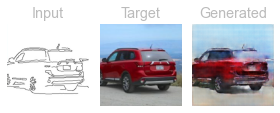

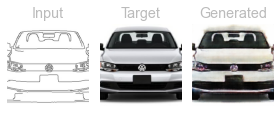

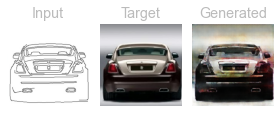

Epoch: 30
82/82 [==============================] - 1919s 773ms/step
Gen loss: 14.131 	 Disc loss: 0.690



In [31]:
losses = fit(gen, disc, g_opt, d_opt, dataset, EPOCHS, BATCH_SIZE, IMG_SIZE, OUTPUT_CHANNELS, LAMBDA_L1)

Text(0.5, 1.0, 'Losses')

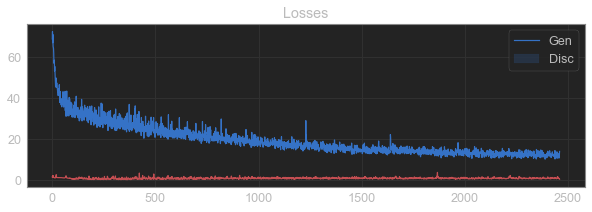

In [32]:
plt.figure(figsize = (10,3))
sns.lineplot(y = losses['gen_loss'], x = list(range(len(losses['gen_loss']))), color = 'b')
sns.lineplot(y = losses['disc_loss'], x = list(range(len(losses['disc_loss']))), color = 'r')
plt.legend(['Gen', 'Disc'])
plt.title("Losses")

Text(0.5, 1.0, 'Discriminator Losses')

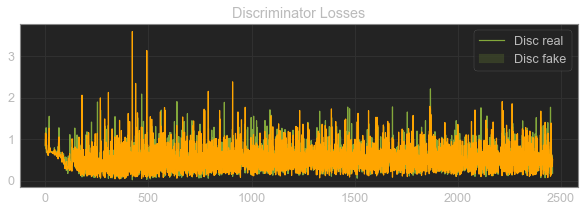

In [33]:
plt.figure(figsize = (10,3))
sns.lineplot(y = losses['disc_real_loss'], x = list(range(len(losses['disc_real_loss']))), color = 'g')
sns.lineplot(y = losses['disc_fake_loss'], x = list(range(len(losses['disc_fake_loss']))), color = 'orange')
plt.legend(['Disc real', 'Disc fake'])
plt.title("Discriminator Losses")

Text(0.5, 1.0, 'Generator Losses')

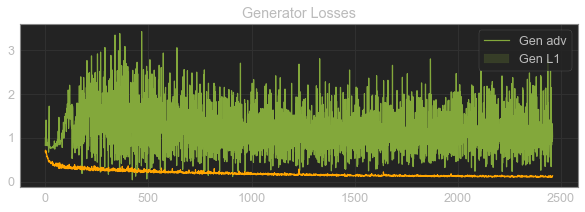

In [34]:
plt.figure(figsize = (10,3))
sns.lineplot(y = losses['gen_adv_loss'], x = list(range(len(losses['gen_adv_loss']))), color = 'g')
sns.lineplot(y = losses['gen_l1_loss'], x = list(range(len(losses['gen_l1_loss']))), color = 'orange')
plt.legend(['Gen adv', 'Gen L1'])
plt.title("Generator Losses")

## Results

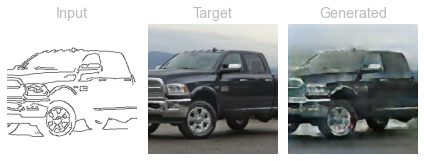

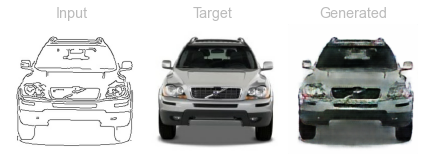

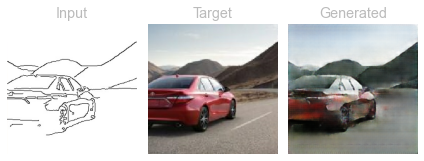

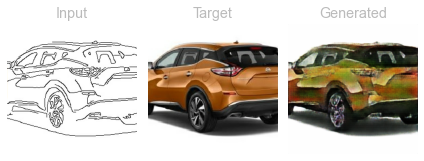

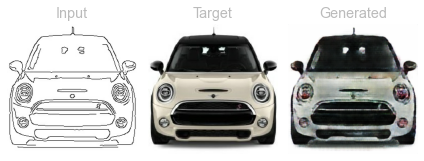

In [36]:
plot_images(gen, dataset, 5, figsize = (6, 3))